## Import module

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
from tensorflow.python.framework import ops


## Restore trained model

In [2]:
# Start a graph session
sess = tf.Session()

saver = tf.train.import_meta_graph('D:/Eun/CNN4PM/savedModel/training_model.ckpt-499.meta')
saver.restore(sess,tf.train.latest_checkpoint('D:/Eun/CNN4PM/savedModel'))


# Load data
data_dir = 'temp'
mnist = read_data_sets(data_dir)

INFO:tensorflow:Restoring parameters from D:/Eun/CNN4PM/savedModel/training_model.ckpt-499
Extracting temp\train-images-idx3-ubyte.gz
Extracting temp\train-labels-idx1-ubyte.gz
Extracting temp\t10k-images-idx3-ubyte.gz
Extracting temp\t10k-labels-idx1-ubyte.gz


In [3]:
# Convert images into 28x28 (they are downloaded as 1x784)
test_xdata = np.array([np.reshape(x, (28,28)) for x in mnist.test.images])

# Convert labels into one-hot encoded vectors
test_labels = mnist.test.labels


In [4]:
# Set model parameters
batch_size = 100
learning_rate = 0.005
image_width = test_xdata[0].shape[0]
image_height = test_xdata[0].shape[1]
num_channels = 1 # greyscale = 1 channel
generations = 500
eval_every = 5
conv1_features = 25
conv2_features = 50
max_pool_size1 = 2 # NxN window for 1st max pool layer
max_pool_size2 = 2 # NxN window for 2nd max pool layer
fully_connected_size1 = 100

In [5]:
# Declare model placeholders
x_input_shape = (batch_size, image_width, image_height, num_channels)
x_input = tf.placeholder(tf.float32, shape=x_input_shape)
y_target = tf.placeholder(tf.int32, shape=(batch_size))

## Get variables from trained model

In [6]:
# Restore model parameters
graph = tf.get_default_graph()

conv1_weight = graph.get_tensor_by_name("conv1_weight:0")
conv1_bias = graph.get_tensor_by_name("conv1_bias:0")

conv2_weight = graph.get_tensor_by_name("conv2_weight:0")
conv2_bias = graph.get_tensor_by_name("conv2_bias:0")

In [7]:
# fully connected variables
resulting_width = image_width // (max_pool_size1 * max_pool_size2)
resulting_height = image_height // (max_pool_size1 * max_pool_size2)
full1_input_size = resulting_width * resulting_height * conv2_features

In [8]:
full1_weight = graph.get_tensor_by_name("full1_weight:0")
full1_bias = graph.get_tensor_by_name("full1_bias:0")
full2_weight = graph.get_tensor_by_name("full2_weight:0")
full2_bias = graph.get_tensor_by_name("full2_bias:0")

In [9]:
# Initialize Model Operations
def my_conv_net(input_data):
    # First Conv-ReLU-MaxPool Layer
    conv1 = tf.nn.conv2d(input_data, conv1_weight, strides=[1, 1, 1, 1], padding='SAME',)
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_bias))
    max_pool1 = tf.nn.max_pool(relu1, ksize=[1, max_pool_size1, max_pool_size1, 1],
                               strides=[1, max_pool_size1, max_pool_size1, 1], padding='SAME')

    # Second Conv-ReLU-MaxPool Layer
    conv2 = tf.nn.conv2d(max_pool1, conv2_weight, strides=[1, 1, 1, 1], padding='SAME')
    relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_bias))
    max_pool2 = tf.nn.max_pool(relu2, ksize=[1, max_pool_size2, max_pool_size2, 1],
                               strides=[1, max_pool_size2, max_pool_size2, 1], padding='SAME')

    # Transform Output into a 1xN layer for next fully connected layer
    final_conv_shape = max_pool2.get_shape().as_list()
    final_shape = final_conv_shape[1] * final_conv_shape[2] * final_conv_shape[3]
    flat_output = tf.reshape(max_pool2, [final_conv_shape[0], final_shape])

    # First Fully Connected Layer
    fully_connected1 = tf.nn.relu(tf.add(tf.matmul(flat_output, full1_weight), full1_bias))

    # Second Fully Connected Layer
    final_model_output = tf.add(tf.matmul(fully_connected1, full2_weight), full2_bias,  name="operation_restore")
    
    return(final_model_output)

In [10]:
model_output = my_conv_net(x_input)                # training

# Create a prediction function
prediction = tf.nn.softmax(model_output,name = 'prediction')


## Feed placeholder and run graph

In [11]:
result = sess.run(prediction, feed_dict={x_input: np.reshape(test_xdata[:100],[100,28,28,1])})

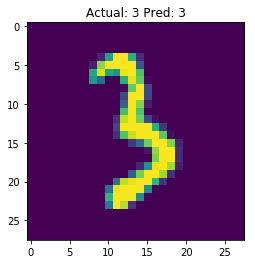

In [12]:


num=random.randrange(0,100)
plt.imshow(test_xdata[num])
plt.title('Actual: ' + str(test_labels[num]) + ' Pred: ' + str(np.argmax(result[num], axis=0)))
plt.show()
    